In [7]:
import numpy as np 
import pandas as pd 
import os
import re    
import nltk  
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
pd.options.plotting.backend = "plotly"
import string
from nltk.tokenize import word_tokenize
from TurkishStemmer import TurkishStemmer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kbraa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
data = pd.read_csv("../dataset/cleaned_Data.csv")
data

,text,sexist
0,tecavüze uğrayan kadınlar saatte dışarda işi v...,1.0
1,küçük turistik sahil kasabasında doğup büyüdüm...,1.0
2,erkek adam ağlamaz cümlesi yerine ağla adam ol...,1.0
3,saygısızlık yapan insanı muhattap almak adam y...,1.0
4,karı ağlama,1.0
...,...,...
2524,kadın işi biliyor abi,0.0
2525,kadının varı yoğunu çalmışlar,0.0
2526,kızlar erkenden eve gitmiş,0.0
2527,kız aniden okuldan ayrıldı,0.0


In [12]:
data['sexist'] = data['sexist'].map({0.0:'not sexist', 1.0:'sexist'})

In [13]:
def tweet_to_words(tweet):

    words = tweet.split()
    # remove stopwords
    # apply stemming
    words = [TurkishStemmer().stem(w) for w in words]
    # return list
    return words

In [14]:
X = list(map(tweet_to_words, data['text']))

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels

le = LabelEncoder()
Y = le.fit_transform(data['sexist'])

In [22]:
print(X[0])


['tecavüz', 'uğrayan', 'kat', 'saatte', 'dışar', 'iş', 'varmış', 'iğrenç', 'yaklaş', 'var', 'bu', 'çocuk', 'okul', 'yol', 'iş', 'var', 'sokak', 'köpek', 'dışar', 'çıkmak', 'haddin', 'haket', 'zaman', 'hay', 'ora', 'çıkaran']


In [23]:
print(Y[0])

1


Train and test split


In [16]:
y = pd.get_dummies(data['sexist'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

Bag of words (BOW) feature extraction¶


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

c:\Users\kbraa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [26]:
data.groupby('sexist').count().plot(kind='bar')

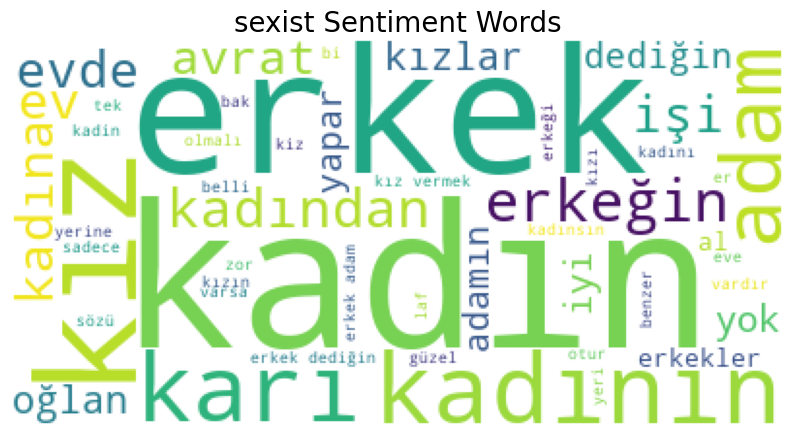

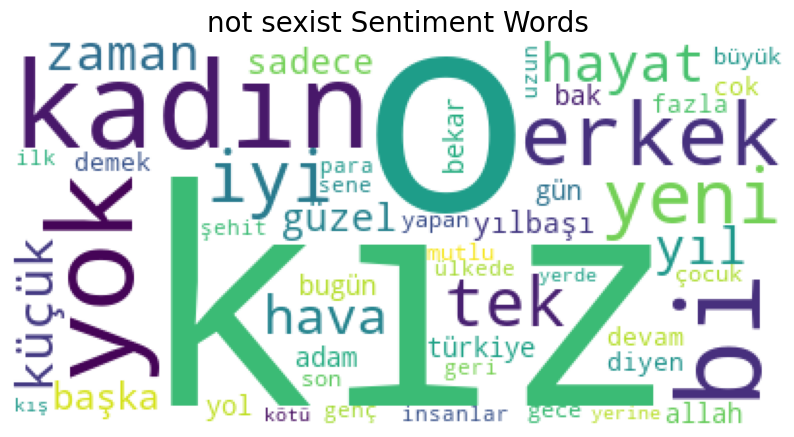

In [27]:

from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(data, category):

    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in data[data.sexist==category].text])
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(data, 'sexist')
     
# Negative tweet words
wordcount_gen(data, 'not sexist')


In [28]:
data.isnull().sum()

text      0
sexist    0
dtype: int64

In [87]:
print(data['sexist'][1802])

nan


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2532 entries, 0 to 2531
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2532 non-null   object
 1   sexist  2525 non-null   object
dtypes: object(2)
memory usage: 39.7+ KB


Tokenizing & Padding¶


In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=100

def tokenize_pad_sequences(text):
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', data['text'][0])
X, tokenizer = tokenize_pad_sequences(data['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 tecavüze uğrayan kadınlar saatte dışarda işi varmışdan iğrenç yaklaşım varsa budur çocuğun okul yolunda işi varmış sokaklar köpeklerin dışarı çıkmak haddine haketmiş zaman hay oraya çıkaranlara
After Tokenization & Padding 
 [2182 2183   89   98  360   18 2184  361 2185   44  690  273  489 1100
   18  691 2186 2187   90  692 2188 2189   30 2190  693 2191    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


Saving tokenized data¶


In [19]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

Train & Test Split


In [20]:
y = pd.get_dummies(data['sexist'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (1517, 100) (1517, 2)
Validation Set -> (506, 100) (506, 2)
Test Set -> (506, 100) (506, 2)


In [21]:
import keras.backend as K

def f1_score(precision, recall):
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [70]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD

vocab_size = 5000
embedding_size = 32
epochs = 41
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=False)

# Build model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=None))  # input_length'i None olarak bıraktık
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))



In [71]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [72]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 32)          160000    
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          3104      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, None, 32)          0         
 g1D)                                                            
                                                                 
 bidirectional_6 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                

In [73]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])


In [74]:
# Train model
batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/41
24/24 [==============================] - 5s 62ms/step - loss: 0.6732 - accuracy: 0.5982 - precision_4: 0.5982 - recall_4: 0.6005 - val_loss: 0.6535 - val_accuracy: 0.6391 - val_precision_4: 0.6391 - val_recall_4: 0.6391
Epoch 2/41
24/24 [==============================] - 1s 23ms/step - loss: 0.6686 - accuracy: 0.6041 - precision_4: 0.6041 - recall_4: 0.6065 - val_loss: 0.6573 - val_accuracy: 0.6391 - val_precision_4: 0.6391 - val_recall_4: 0.6391
Epoch 3/41
24/24 [==============================] - 1s 27ms/step - loss: 0.6690 - accuracy: 0.6067 - precision_4: 0.6067 - recall_4: 0.6091 - val_loss: 0.6529 - val_accuracy: 0.6391 - val_precision_4: 0.6391 - val_recall_4: 0.6391
Epoch 4/41
24/24 [==============================] - 1s 23ms/step - loss: 0.6690 - accuracy: 0.6061 - precision_4: 0.6061 - recall_4: 0.6085 - val_loss: 0.6625 - val_accuracy: 0.6391 - val_precision_4: 0.6391 - val_recall_4: 0.6391
Epoch 5/41
24/24 [==============================] - 1s 24ms/step - loss: 0.6

In [33]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))




Accuracy  : 0.8755
Precision : 0.8755
Recall    : 0.8755
F1 Score  : 0.8755


In [ ]:
def plot_training_hist(history):
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

Model Confusion Matrix¶


16/16 [==============================] - 1s 8ms/step


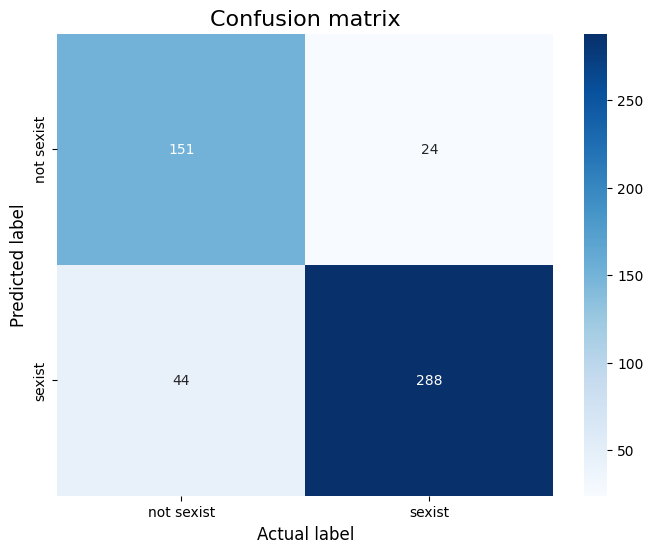

In [77]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['not sexist', 'sexist']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

Model save and load for the prediction

In [79]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [1]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    
    sentiment_classes = ['not sexist', 'sexist']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [2]:
stop_words_list = {'a','acaba','altı','altmış','ama','ancak','arada','artık','asla','aslında','ayrıca','az','bana','bazen','bazı''bazıları',
'belki','ben','benden','beni','benim','beri','beş','bile','bilhassa','bin','bir','biraz','birçoğu','birçok','biri','birisi','birkaç',
'birşey','biz','bizden','bize','bizi','bizim','böyle','böylece','bu','buna','bunda','bundan','bunlar','bunları','bunların','bunu',
'bunun','burada','bütün','çoğu','çoğunu','çok','çünkü','da','daha','dahi','dan','de','defa','değil','diğer','diğeri','diğerleri','diye',
'doksan','dokuz','dolayı','dolayısıyla','dört','ee','edecek','eden','ederek','edilecek','ediliyor','edilmesi','ediyor','eğer','elbette',
'elli','en','etmesi','etti','ettiği','ettiğini','fakat','falan','filan','gene','gereği','gerek','gibi','göre','hala','halde','halen','hangi','hangisi',
'hani','hatta','hem','henüz','hep','hepsi','her','herhangi','herkes','herkese','herkesi','herkesin','hiç','hiçbir','hiçbiri','için','içinde',
'iki','ile','ilgili','ise','işte','itibaren','itibariyle','kaç','kadar','karşın','kendi','kendilerine','kendine','kendini','kendisi','kendisine','kendisini','kez','ki',
'kim','kime','kimi','kimin','kimisi','kimse','kırk','madem','mi','mı','milyar','milyon','mu','mü','nasıl','ne','neden','nedenle','nerde','nerede',
'nereye','neyse','niçin','nin','nın','niye','nun','nün','öbür','olan','olarak','oldu','olduğu','olduğunu','olduklarını','olmadı','olmadığı','olmak',
'olması','olmayan','olmaz','olsa','olsun','olup','olur','olur','olursa','oluyor','on','ön','ona','önce','ondan','onlar','onlara','onlardan',
'onları','onların','onu','onun','orada','öte','ötürü','otuz','öyle','oysa','pek','rağmen','sana','sanki','sanki','şayet','şekilde','sekiz','seksen','sen','senden','seni','senin','şey',
'şeyden','şeye','şeyi','şeyler','şimdi','siz','siz','sizden','size','sizi','sizin','sizin','sonra','şöyle','şu'
,'şuna','şunları','şunu','ta','tabii','tam','tamam','tamamen','tarafından','trilyon','tüm','tümü','üç','un','ün','üzere','var','vardı','ve','veya',
'ya','yani','yapacak','yapılan','yapılması','yapıyor','yapmak','yaptı','yaptığı','yaptığını','yaptıkları','ye','yedi','yetmiş','yi','yı','yine','yirmi','yoksa','yu','yüz','zaten','zira'}


In [23]:

def veri_temizleme(text):
    # Küçük harfe çevirme
    text = text.lower()
    #kesme işareti ve sonrasındaki karakterlerin kaldırılması
    text = re.sub("'(\w+)","",text)
    text = re.sub("[“,`,',’,\",❞]"," ",text)
    # Noktalama işaretlerini kaldırma
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    #Yeni satır karakterleri, boşluk karakteri ile değiştirme
    text = text.replace("\\n"," ")
    # URL'leri kaldırma
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Sayıları kaldırma
    text = re.sub(r'\d+', '', text)
    # Kullanıcı adlarını kaldırma
    text = re.sub(r'@\S+', '', text)
    # Hashtag'leri kaldırma
    text = re.sub(r'#\S+', '', text)
    # Emoji'leri kaldırma
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Stopwords'leri kaldırma
    stop_words = set(stop_words_list)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    # Tekrar eden boşlukları kaldırma
    text = ' '.join(words)
    #text = duzelt_yazi_zemberek(text)
    return text

In [5]:
import re

In [30]:
def sonuc(text):
    text = veri_temizleme(text)
    predict_class([text])

sonuc('saçı uzun aklı kısa')

1/1 [==============================] - 0s 53ms/step
The predicted sentiment is sexist
